In [1]:
import requests
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [2]:
from pathlib import Path
import os
base_dir = r"D:\out\classes\CS526 data science\project\data"


dfs = []
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if os.path.isdir(folder_path):
        file_path = os.path.join(folder_path, "T_ONTIME_REPORTING.csv") 
        if os.path.exists(file_path):
            df = pd.read_csv(file_path,dtype={'CRS_DEP_TIME': str})
            df["source_folder"] = folder_name  
            dfs.append(df)
        else:
            print(f"⚠️ {file_path} not existing")


merged_df = pd.concat(dfs, ignore_index=True)
merged_df = merged_df[merged_df['ORIGIN_CITY_NAME'] == 'Raleigh/Durham, NC']
merged_df['FL_DATE'] = pd.to_datetime(merged_df['FL_DATE'])
merged_df = merged_df.sort_values('FL_DATE')

C:\Users\ljq\AppData\Local\Temp\ipykernel_8604\1405787254.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['FL_DATE'] = pd.to_datetime(merged_df['FL_DATE'])


In [3]:
weather = pd.read_csv("clean_weather_RDU_2022_2024.csv")
weather["DATE"] = pd.to_datetime(weather["DATE"])
weather = weather.sort_values("DATE")

In [4]:
flight=merged_df
flight['CRS_DEP_TIME'] = flight['CRS_DEP_TIME'].astype(str).str.strip()
valid_mask = flight['CRS_DEP_TIME'].str.fullmatch(r'\d{4}', na=False)
invalid_rows = flight[~valid_mask]
invalid_count = len(invalid_rows)
invalid_ratio = invalid_count / len(flight) * 100
print(invalid_rows)
print(invalid_count)
print(invalid_ratio)

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, FL_DATE, ORIGIN_AIRPORT_ID, ORIGIN_AIRPORT_SEQ_ID, ORIGIN_CITY_MARKET_ID, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST_AIRPORT_ID, DEST_AIRPORT_SEQ_ID, DEST_CITY_MARKET_ID, DEST, DEST_CITY_NAME, DEST_STATE_ABR, CRS_DEP_TIME, DEP_TIME, DEP_DELAY, DEP_DELAY_NEW, DEP_DEL15, CANCELLED, WEATHER_DELAY, source_folder]
Index: []

[0 rows x 25 columns]
0
0.0


In [5]:
flight = flight[valid_mask].copy()
flight = flight.reset_index(drop=True)

In [6]:
flight['CRS_DEP_TIME'] = flight['CRS_DEP_TIME'].astype(str).str.zfill(4)
flight['CRS_DEP_HOUR'] = flight['CRS_DEP_TIME'].str[:2].astype(int)
flight['CRS_DEP_MIN'] = flight['CRS_DEP_TIME'].str[2:].astype(int)
flight['CRS_DEP_DATETIME'] = flight.apply(
    lambda row: row['FL_DATE'] + pd.Timedelta(hours=row['CRS_DEP_HOUR'], minutes=row['CRS_DEP_MIN']),
    axis=1
)
flight = flight.sort_values('CRS_DEP_DATETIME')

In [7]:
merged = pd.merge_asof(
    flight,
    weather,
    left_on="CRS_DEP_DATETIME",
    right_on="DATE",
    direction="nearest",   
    tolerance=pd.Timedelta("1H")  
)
merged

C:\Users\ljq\AppData\Local\Temp\ipykernel_8604\1250268331.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta("1H")


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,...,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,DateTime,Airport
0,2022,1,1,1,2022-01-01,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,2022-01-01 05:51:00,RDU
1,2022,1,1,1,2022-01-01,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,2022-01-01 05:51:00,RDU
2,2022,1,1,1,2022-01-01,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,2022-01-01 05:51:00,RDU
3,2022,1,1,1,2022-01-01,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,2022-01-01 05:51:00,RDU
4,2022,1,1,1,2022-01-01,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,2022-01-01 05:51:00,RDU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174776,2024,4,12,31,2024-12-31,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,2024-12-31 19:51:00,RDU
174777,2024,4,12,31,2024-12-31,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,2024-12-31 19:51:00,RDU
174778,2024,4,12,31,2024-12-31,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,2024-12-31 19:51:00,RDU
174779,2024,4,12,31,2024-12-31,14492,1449202,34492,RDU,"Raleigh/Durham, NC",...,NaN,84.0,SCT:04 8.84 SCT:04 21.34 BKN:07 33.53,1002.5,16.093,190,NaN,2.6,2024-12-31 20:51:00,RDU


In [8]:
merged["time_diff_min"] = (merged["CRS_DEP_DATETIME"] - merged["DATE"]).abs().dt.total_seconds() / 60

In [9]:
df=merged[['WEATHER_DELAY','DEP_DELAY','DEP_DEL15','CANCELLED','CRS_DEP_DATETIME','HourlyDewPointTemperature','HourlyDryBulbTemperature',
'HourlyPrecipitation','HourlyPresentWeatherType','HourlyPressureChange','HourlyPressureTendency','HourlyRelativeHumidity','HourlySkyConditions',
'HourlySeaLevelPressure','HourlyVisibility','HourlyWindDirection','HourlyWindGustSpeed','HourlyWindSpeed','time_diff_min']]
print(df)

        WEATHER_DELAY  DEP_DELAY  DEP_DEL15  CANCELLED    CRS_DEP_DATETIME  \
0                 0.0       64.0        1.0        0.0 2022-01-01 05:30:00   
1                 NaN       -8.0        0.0        0.0 2022-01-01 05:40:00   
2                 NaN       -7.0        0.0        0.0 2022-01-01 05:45:00   
3                 NaN       -3.0        0.0        0.0 2022-01-01 06:00:00   
4                 NaN       -7.0        0.0        0.0 2022-01-01 06:00:00   
...               ...        ...        ...        ...                 ...   
174776            NaN      -10.0        0.0        0.0 2024-12-31 19:45:00   
174777            NaN       -9.0        0.0        0.0 2024-12-31 19:47:00   
174778            NaN      -17.0        0.0        0.0 2024-12-31 20:10:00   
174779            NaN      -12.0        0.0        0.0 2024-12-31 20:26:00   
174780            NaN      -15.0        0.0        0.0 2024-12-31 21:57:00   

        HourlyDewPointTemperature  HourlyDryBulbTemperature  \


In [10]:
nan_counts =df.isna().sum()
print(nan_counts)

WEATHER_DELAY                140278
DEP_DELAY                      3411
DEP_DEL15                      3411
CANCELLED                         0
CRS_DEP_DATETIME                  0
HourlyDewPointTemperature       179
HourlyDryBulbTemperature        172
HourlyPrecipitation           31500
HourlyPresentWeatherType     156841
HourlyPressureChange         114102
HourlyPressureTendency       114102
HourlyRelativeHumidity          179
HourlySkyConditions           15691
HourlySeaLevelPressure        10078
HourlyVisibility               9421
HourlyWindDirection           32484
HourlyWindGustSpeed          155854
HourlyWindSpeed                 237
time_diff_min                   172
dtype: int64


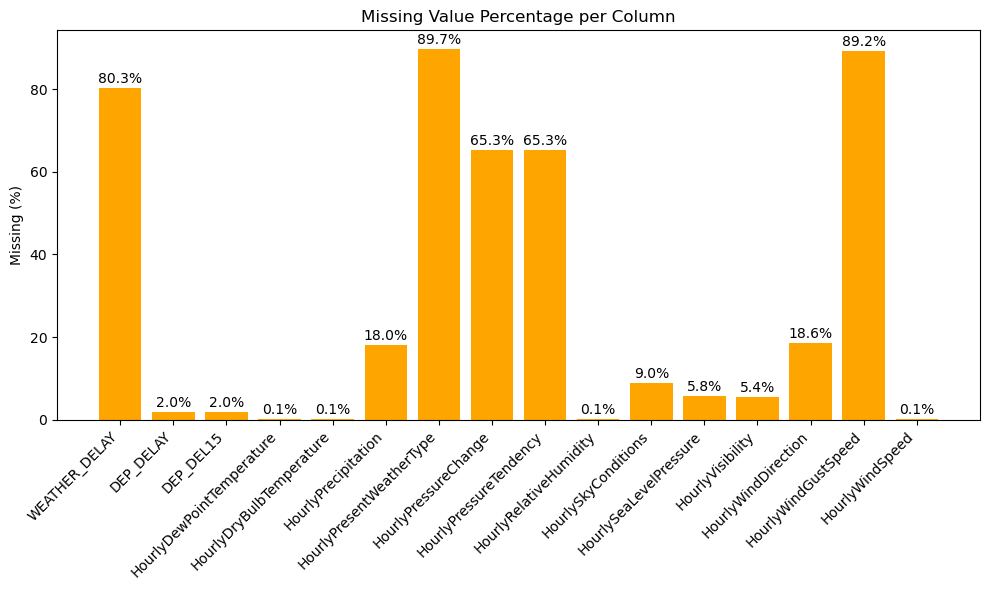

In [11]:
newdf=merged[['WEATHER_DELAY','DEP_DELAY','DEP_DEL15','CANCELLED','CRS_DEP_DATETIME','HourlyDewPointTemperature','HourlyDryBulbTemperature',
'HourlyPrecipitation','HourlyPresentWeatherType','HourlyPressureChange','HourlyPressureTendency','HourlyRelativeHumidity','HourlySkyConditions',
'HourlySeaLevelPressure','HourlyVisibility','HourlyWindDirection','HourlyWindGustSpeed','HourlyWindSpeed']]
na_percent = (newdf.isna().sum() / len(newdf)) * 100
na_percent = na_percent[na_percent > 0]


plt.figure(figsize=(10,6))
bars = plt.bar(na_percent.index, na_percent.values, color='orange')
for bar, pct in zip(bars, na_percent.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)
plt.title("Missing Value Percentage per Column")
plt.ylabel("Missing (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("missing_values.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
print(df['time_diff_min'].mean())

12.964005291823446


In [13]:
df=df[df['CANCELLED'] != 1]
df=df.drop(columns=['CANCELLED'])
df=df.dropna(subset=['DEP_DELAY'])

In [14]:
df

,WEATHER_DELAY,DEP_DELAY,DEP_DEL15,CRS_DEP_DATETIME,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,time_diff_min
0,0.0,64.0,1.0,2022-01-01 05:30:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,21.0
1,NaN,-8.0,0.0,2022-01-01 05:40:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,11.0
2,NaN,-7.0,0.0,2022-01-01 05:45:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,6.0
3,NaN,-3.0,0.0,2022-01-01 06:00:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,9.0
4,NaN,-7.0,0.0,2022-01-01 06:00:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174776,NaN,-10.0,0.0,2024-12-31 19:45:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,6.0
174777,NaN,-9.0,0.0,2024-12-31 19:47:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,4.0
174778,NaN,-17.0,0.0,2024-12-31 20:10:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,19.0
174779,NaN,-12.0,0.0,2024-12-31 20:26:00,11.7,14.4,0.0,NaN,NaN,NaN,84.0,SCT:04 8.84 SCT:04 21.34 BKN:07 33.53,1002.5,16.093,190,NaN,2.6,25.0


In [15]:
count = (df['DEP_DELAY'].abs() >= 60).sum()
print(count/len(df))

0.07311633338198803


In [16]:
count = (df['DEP_DELAY'].abs() >= 30).sum()
print(count/len(df))

0.12952269741643554


In [17]:
print(365*3*12/float(len(weather)))

0.3642007816181158


In [18]:
df = df[df['DEP_DELAY'].abs() <= 60]#1 hour

In [19]:
df_copy=df.copy()
df_copy

,WEATHER_DELAY,DEP_DELAY,DEP_DEL15,CRS_DEP_DATETIME,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,time_diff_min
1,NaN,-8.0,0.0,2022-01-01 05:40:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,11.0
2,NaN,-7.0,0.0,2022-01-01 05:45:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,6.0
3,NaN,-3.0,0.0,2022-01-01 06:00:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,9.0
4,NaN,-7.0,0.0,2022-01-01 06:00:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,9.0
5,NaN,-6.0,0.0,2022-01-01 06:00:00,18.9,19.4,0.0,NaN,NaN,NaN,97.0,OVC:08 2.13,1011.4,16.093,220.0,NaN,4.1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174776,NaN,-10.0,0.0,2024-12-31 19:45:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,6.0
174777,NaN,-9.0,0.0,2024-12-31 19:47:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,4.0
174778,NaN,-17.0,0.0,2024-12-31 20:10:00,11.1,13.9,0.0,NaN,NaN,NaN,83.0,FEW:02 8.84 FEW:02 13.72,1003.0,16.093,000,NaN,0,19.0
174779,NaN,-12.0,0.0,2024-12-31 20:26:00,11.7,14.4,0.0,NaN,NaN,NaN,84.0,SCT:04 8.84 SCT:04 21.34 BKN:07 33.53,1002.5,16.093,190,NaN,2.6,25.0


In [20]:
cloud_types = ["OVC", "BKN", "SCT", "CLR"]
import re
def count_cloud_types(s):
    if pd.isna(s):
        return pd.Series({c: 0 for c in cloud_types})
    counts = {}
    for c in cloud_types:
        counts[c] = len(re.findall(r'\b{}\b'.format(c), str(s)))
    return pd.Series(counts)

cloud_counts = df["HourlySkyConditions"].apply(count_cloud_types)
df = pd.concat([df, cloud_counts], axis=1)

# Weather type encoding
weather_types = ["RA", "SN", "DZ", "FZRA", "PL", "TS", "FG", "BR"]

def encode_weather(s):
    if pd.isna(s):
        return pd.Series({w: 0 for w in weather_types})
    s = str(s).upper()
    result = {}
    for w in weather_types:
        result[w] = 0
        matches = re.findall(r'([+-]?){0}(:\d+)?'.format(w), s)
        if matches:
            for m in matches:
                prefix = m[0]
                if prefix == '+':
                    val = 1
                elif prefix == '-':
                    val = -1
                else:
                    val = 0
                result[w] = max(result[w], val)
    return pd.Series(result)

weather_encoded = df["HourlyPresentWeatherType"].apply(encode_weather)
df = pd.concat([df, weather_encoded], axis=1)

df["HourlyPrecipitation"] = df["HourlyPrecipitation"].replace("T", 0).astype(float)

feature_columns = [ 'HourlyDewPointTemperature', 
                  'HourlyDryBulbTemperature', 'HourlyPrecipitation',
                  'HourlyPressureChange', 'HourlyPressureTendency',
                  'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
                  'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
                  ]+cloud_types +weather_types

df_reg = df[['DEP_DELAY'] + feature_columns ].copy()

In [21]:
non_numeric = df_reg.select_dtypes(exclude=['number']).columns
for i in non_numeric:
    df_reg[i] = pd.to_numeric(df_reg[i], errors='coerce')
df_reg

,DEP_DELAY,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyVisibility,HourlyWindGustSpeed,...,SCT,CLR,RA,SN,DZ,FZRA,PL,TS,FG,BR
1,-8.0,18.9,19.4,0.0,NaN,NaN,97.0,1011.4,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
2,-7.0,18.9,19.4,0.0,NaN,NaN,97.0,1011.4,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
3,-3.0,18.9,19.4,0.0,NaN,NaN,97.0,1011.4,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
4,-7.0,18.9,19.4,0.0,NaN,NaN,97.0,1011.4,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
5,-6.0,18.9,19.4,0.0,NaN,NaN,97.0,1011.4,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174776,-10.0,11.1,13.9,0.0,NaN,NaN,83.0,1003.0,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
174777,-9.0,11.1,13.9,0.0,NaN,NaN,83.0,1003.0,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
174778,-17.0,11.1,13.9,0.0,NaN,NaN,83.0,1003.0,16.093,NaN,...,0,0,0,0,0,0,0,0,0,0
174779,-12.0,11.7,14.4,0.0,NaN,NaN,84.0,1002.5,16.093,NaN,...,2,0,0,0,0,0,0,0,0,0


In [22]:
df_reg = df_reg.dropna(thresh=df_reg.shape[1] - 2)
imputer = IterativeImputer(random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df_reg), columns=df_reg.columns)
df_reg=df_imputed
df_reg

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,DEP_DELAY,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyVisibility,HourlyWindGustSpeed,...,SCT,CLR,RA,SN,DZ,FZRA,PL,TS,FG,BR
0,-1.0,19.4,20.0,0.000000,-0.5,6.0,96.0,1011.3,9.656,9.243378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-4.0,19.4,20.0,0.000000,-0.5,6.0,96.0,1011.3,9.656,9.230387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9.0,19.4,20.0,0.000000,-0.5,6.0,96.0,1011.3,9.656,9.208734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.0,19.4,20.0,0.000000,-0.5,6.0,96.0,1011.3,9.656,9.234717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-8.0,19.4,20.0,0.000000,-0.5,6.0,96.0,1011.3,9.656,9.213065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58976,20.0,11.1,15.0,0.000000,0.0,3.0,78.0,1003.4,16.093,8.663025,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58977,-8.0,11.1,15.0,0.000000,0.0,3.0,78.0,1003.4,16.093,8.541771,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58978,-11.0,11.1,15.0,0.234332,0.1,2.0,78.0,1003.4,16.000,8.859928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58979,-6.0,11.1,15.0,0.240234,0.1,2.0,78.0,1003.4,16.000,8.882053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_reg.to_csv("output.csv", index=False)

In [23]:
X = df_reg[feature_columns]
y = df_reg['DEP_DELAY']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (58981, 22)
Target shape: (58981,)


In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns, index=X.index)
X=X_normalized_df

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

KeyboardInterrupt: 

In [28]:
# after tuning
rf = RandomForestRegressor(random_state=42,max_depth=20,min_samples_split=2,n_estimators=300)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R² = {r2:.3f}")

MAE = 7.214
RMSE = 11.491
R² = 0.295


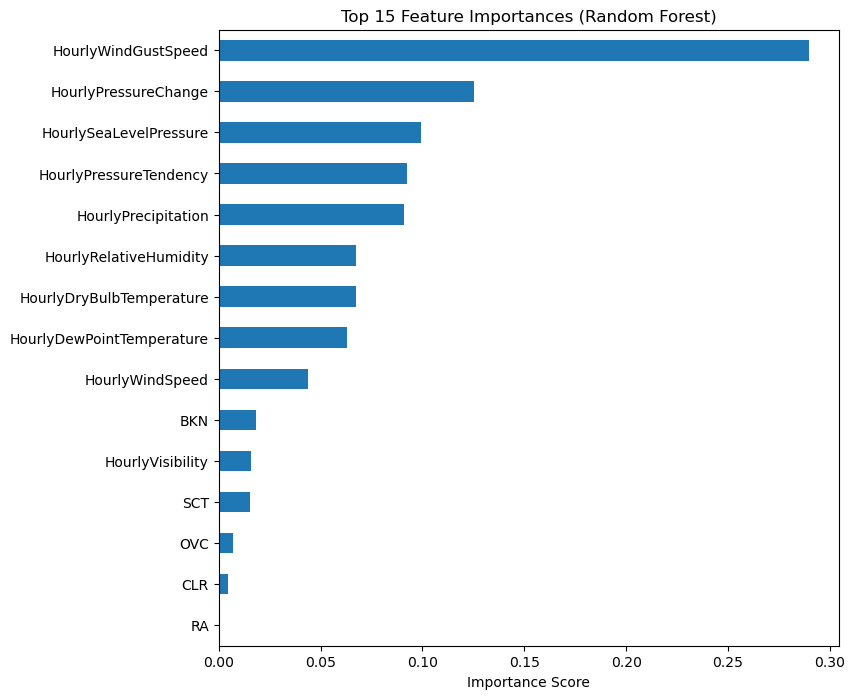

In [30]:
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8,8))
importances.tail(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.savefig("feature importance.png", dpi=300, bbox_inches='tight')
plt.show()

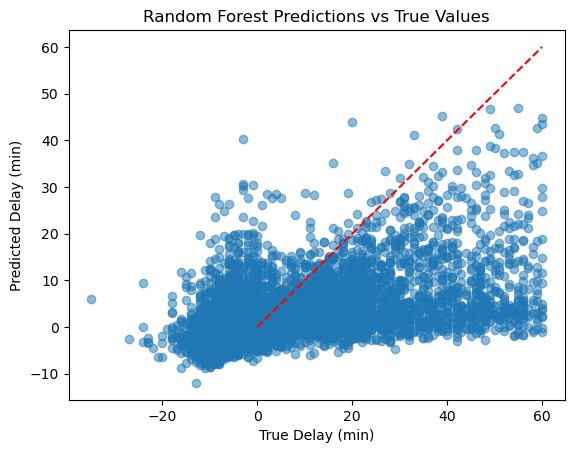

In [31]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Random Forest Predictions vs True Values")
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--') 
plt.savefig("rf_pred_vs_true.png", dpi=300, bbox_inches='tight')
plt.show()

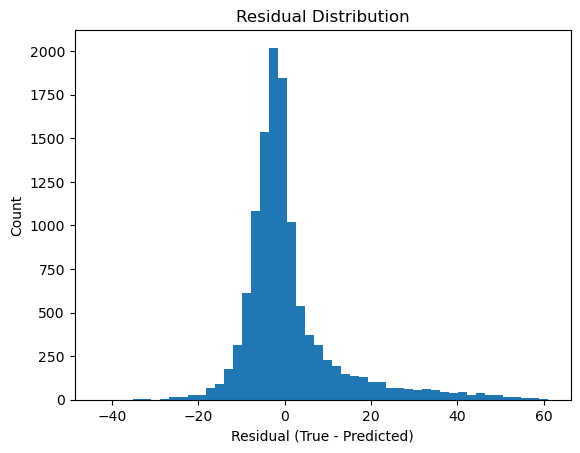

In [32]:
residuals = y_test - y_pred

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.show()

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df['DEP_DELAY'].plot.box()
plt.title("Boxplot of DEP_DELAY")
plt.ylabel("Values")
plt.savefig("boxplot_DEP_DELAY.png", dpi=300, bbox_inches='tight') 
plt.close()  